<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 3 &ndash; Recurrent Neural Networks (Assignment)</h2>

In [1]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

# Check minimum versions.
u4.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.22.4 (✓)
Installed pandas version: 1.5.3 (✓)
Installed PyTorch version: 2.0.1+cu118 (✓)
Installed matplotlib version: 3.7.1 (✓)
Installed seaborn version: 0.12.2 (✓)


<a name="exercise-latch-sequence-set"></a><h2>The Latch Sequence Data Set</h2>
<p>In the accompanying excercise class, the <i>latch task</i> was presented. You'll be working with the same data set in this assignment. The original latch task was introduced by Hochreiter and Mozer:
<center>
    <cite>Sepp Hochreiter, Michael Mozer, 2001. A discrete probabilistic memory model for discovering dependencies in time. Artificial Neural Networks -- ICANN 2001, 13, pp.661-668.</cite>
</center></p>

<p>The essence of this task is that a sequence of inputs is presented, beginning with one of two symbols, <b>A</b> or <b>B</b>, and after a variable number of time steps, the model has to output a corresponding symbol. Thus, the task requires memorizing the original input over time. It has to be noted that in the <i>original</i> task desription, both class-defining symbols must only appear at the first position of an instance.</p>

<p>The modified version of this task used in this assignment is identical to the one discussed during the accompanying exercise, with the difference of a higher amount of possible targets. Defining arguments are:

<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this assignment)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_samples</code></th>
        <th>5000</th>
        <th>Amount of samples of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>56</th>
        <th>Amount of instances per sample (sample length).</th>
    </tr>
    <tr>
        <th><code>num_characters</code></th>
        <th>20</th>
        <th>Amount of different characters (size of the one-hot encoded vector).</th>
    </tr>
    <tr>
        <th><code>num_targets</code></th>
        <th>19</th>
        <th>Amount of different characters used as possible targets.</th>
    </tr>
    <tr>
        <th><code>seed</code></th>
        <th>23</th>
        <th>Random seed used to generate the samples of the data set.</th>
    </tr>
</table></p>

<div class="alert alert-warning">
    <b>Exercise 1.1. [12 Points]</b>
    <ul>
        <li>Generate a <i>latch sequence</i> data set with the properties as described in the table <i>above</i>.</li>
        <li>Visualize the last sequence of the data set in <i>tabular</i> form, with all $1$ in <b style="color:green">bold green</b> and all $0$ in <span style="font-weight: lighter">lighter</span> default font color.</li>
        <li>Visualize the <i>first</i> $20$ samples in a heatmap, once <i>without</i> and once <i>with</i> a corresponding prefix-mask.</li>
    </ul>
</div>

In [2]:
data_latch = u4.LatchSequenceSet(
    num_samples = 5000,
    num_instances = 56,
    num_characters = 20,
    num_targets = 19,
    seed = 23
)

data_sample = pd.DataFrame(data_latch[-1][0].transpose(0, 1)).astype(int)
data_sample.index = [chr(65 + i) for i in data_sample.index]
data_sample.style.applymap(lambda x: 'color: green; font-weight: bold' if x == 1 else 'color: default; front-weight: light')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
A,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
F,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
G,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
H,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


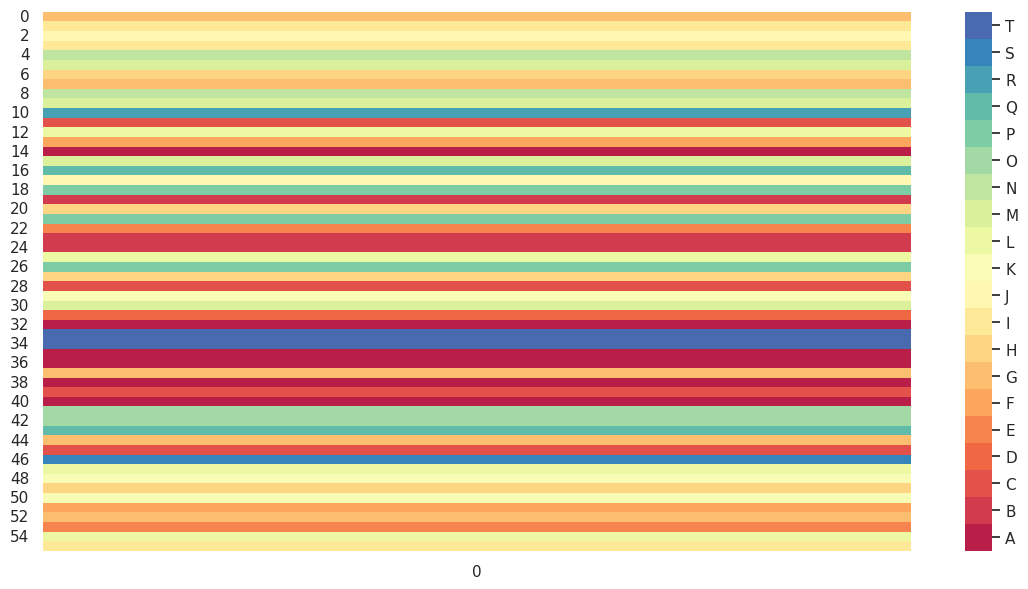

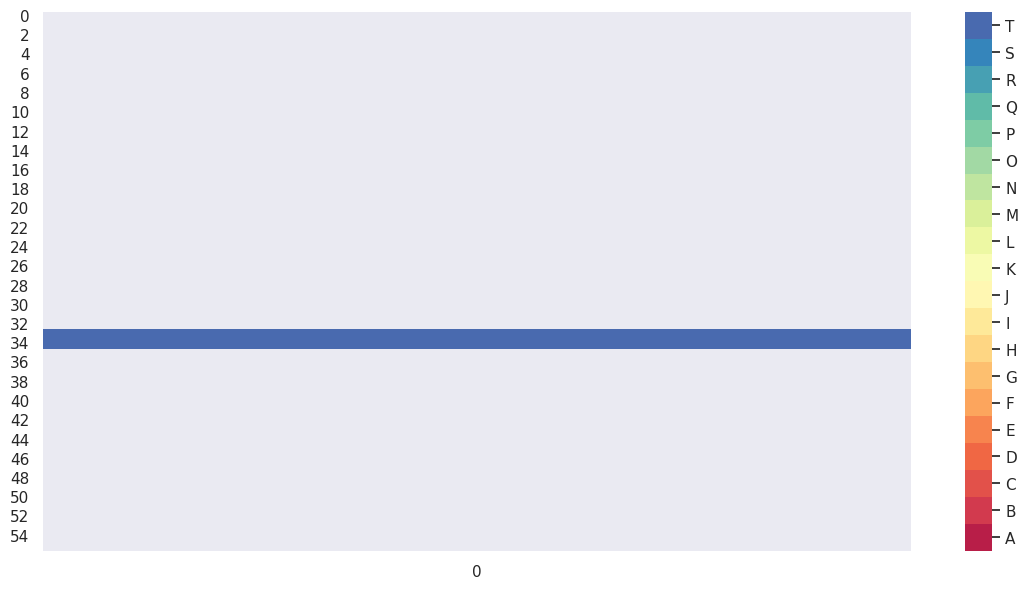

In [3]:
u4.set_seed(23)

data_heatmap = next(iter(data_latch))[0]
data_heatmap = pd.DataFrame(data_heatmap.argmax(dim=1))
u4.plot_heatmap(data=data_heatmap, figsize=(14, 7))
u4.plot_heatmap(data=data_heatmap, prefix_mask=True, prefix_index=data_latch.num_targets, figsize=(14, 7))

<div class="alert alert-warning">
    <b>Exercise 1.2. [16 Points]</b>
    <ul>
        <li>Linearly split the data set into a <i>training</i> and a <i>test</i> set in a ratio of $4 : 1$ (use a <code>SubsetRandomSampler</code> and a batch size of $48$).</li>
        <li>Compute and print the <i>amount of samples</i> of each of the respective sets and verify the $4 : 1$ split.</li>
        <li>Visualize the <i>character counts</i> of the <i>first</i> training minibatch appropriately. What is the count of the <i>prefix</i> character? Provide a formula as a function of the <i>batch_size</i> to compute the count of the <i>prefix</i> character.</li>
    </ul>
</div>

The training set: "4000" sampler
The test set: "1000" sampler


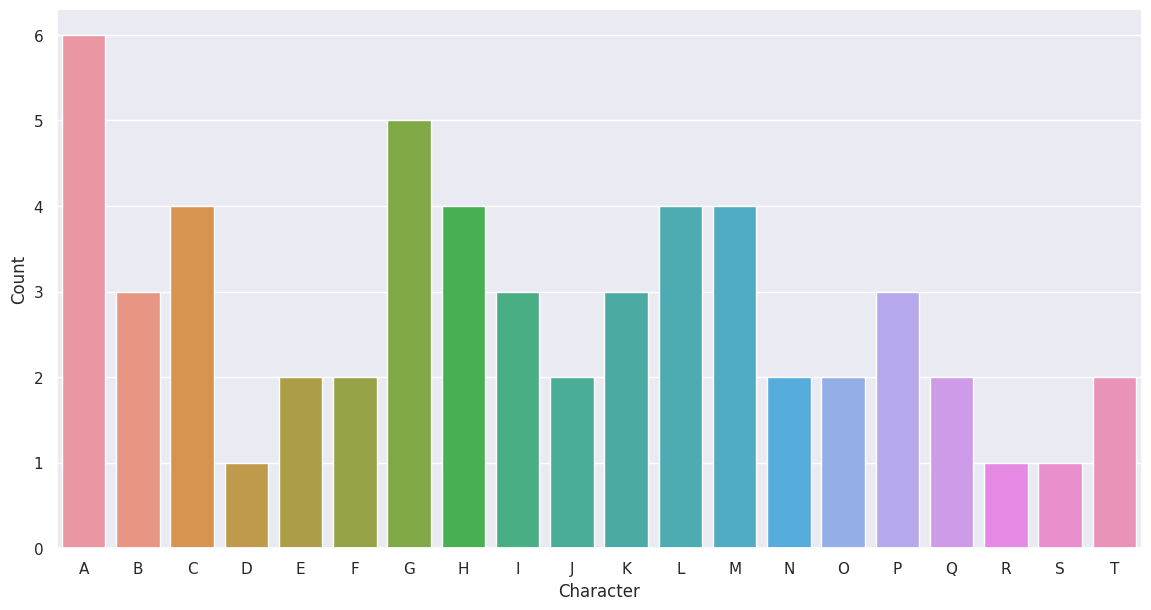

912


In [4]:
batch_size = 48
test_size = data_latch.num_samples // 5

sampler_train = torch.utils.data.SubsetRandomSampler(range(test_size, data_latch.num_samples))
data_loader_train = torch.utils.data.DataLoader(
    dataset = data_latch,
    batch_size = batch_size,
    sampler = sampler_train
)

sampler_test = torch.utils.data.SubsetRandomSampler(range(test_size))
data_loader_test = torch.utils.data.DataLoader(
    dataset = data_latch,
    batch_size = batch_size,
    sampler = sampler_test
)

print(f'The training set: "{len(sampler_train)}" sampler')
print(f'The test set: "{len(sampler_test)}" sampler')

data_histogram = data_heatmap.to_numpy().flatten()
fig, ax = plt.subplots(figsize=(14, 7))
count_plot = sns.countplot(x=data_histogram, ax=ax)
ax.set_xticklabels([chr(65 + i) for i in ax.get_xticks()])
ax.set_xlabel('Character')
ax.set_ylabel('Count')
plt.show()

count_prefix = batch_size * data_latch.num_targets
print(count_prefix)

<a name="exercise-latch-cnn"></a><h2>Tackling Sequence Data with CNNs</h2>
<p>During the accompanying exercise class, a <i>dense feed-forward</i> network was presented as some kind of baseline. Afterwards, recurrent architectures were applied. In this exercise, you'll be tasked with implementing a <i>convolutional</i> architecture for handling sequence data.</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [5]:
class TheMightyDice(torch.nn.Module):
    """
    Dice roll "network" tailored to deliver random outcomes.
    """

    def __init__(self, output_size: int):
        super().__init__()
        self.__output_size = output_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(size=(x.shape[0], self.__output_size), device=x.device)


def count_parameters(model: torch.nn.Module, only_trainable: bool = True) -> int:
    """
    Count (trainable) paramaters of specified model.

    :param model: model for which to compute the amount of (trainable) parameters
    :param only_trainable: only include trainable parameters in total count
    :return: amount of (trainable) parameters of the specified model
    """
    return sum(parameter.numel() for parameter in model.parameters() if any(
        (not only_trainable, only_trainable and parameter.requires_grad)))

<div class="alert alert-warning">
    <b>Exercise 2.1. [7 Points]</b>
    <ul>
        <li>Test a <code>TheMightyDice</code> instance on the latch sequence <i>test</i> set.
    </ul>
</div>

In [6]:
u4.set_seed(23)

target_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

performance = u4.test_network(
    model = TheMightyDice(output_size = data_latch.num_targets).to(device = target_device),
    data_loader = data_loader_test,
    device = target_device
)

print(f'Final loss: {performance[0]: .4f} / Final accuracy: {performance[1]: .4f}')

Final loss:  0.0627 / Final accuracy:  0.0490


<div class="alert alert-warning">
    <b>Exercise 2.2. [26 Points]</b>
    <ul>
        <li>Implement a class <code>CNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$192$ output channels and a configurable kernel size (specified as an argument to <code>__init__</code>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$192$ output channels and the same kernel size as the <i>1D convolution</i> at position $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>6</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>CNN</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters (use <code>count_parameters</code> from above). Use a <i>kernel size</i> of $1$.</li>
        <li>Repeat the same procedure with a second <code>CNN</code> but a <i>kernel size</i> of $3$.</li>
        <li>Hints:</li>
        <ul>
            <li>With the parameterized kernel size, you cannot hard-code the flattened number of elements for the linear layer input. Instead, you have to calculate it using the length of the input (<code>data_latch.num_instances</code>), which might be a good idea to pass into <code>__init__</code> as well. Each convolutional layer then reduces this length by <code>kernel_size - 1</code>.</li>
            <li><code>Conv1d</code> expects the minibatch input shape <code>(N, C, L)</code>, but the latch data has a minibatch shape of <code>(N, L, C)</code>. Thus, in your <code>forward</code> method, you will first have to transform the input minibtach into the correct shape before you can apply the network architecture. There are several ways to do this, e.g., <a href="https://pytorch.org/docs/stable/generated/torch.transpose.html">transposing</a> or <a href="https://pytorch.org/docs/stable/generated/torch.movedim.html">moving dimensions</a>.</li>
        </ul>
    </ul>
</div>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self, kernel_size, num_targets, num_instances):
        super(CNN, self).__init__()
        self.kernel_size = kernel_size
        self.num_targets = num_targets
        self.num_instances = num_instances
        self.conv1 = nn.Conv1d(20, 192, kernel_size)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(192, 192, kernel_size)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(192 * (num_instances - 2 * (kernel_size - 1)), num_targets)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set the parameters for training
num_epochs = 12
learning_rate = 0.01

# Create an instance of the CNN model
cnn_kernel1 = CNN(kernel_size=1, num_targets=data_latch.num_targets, num_instances=data_latch.num_instances)
cnn_kernel3 = CNN(kernel_size=3, num_targets=data_latch.num_targets, num_instances=data_latch.num_instances)

# Define the optimizer and loss function
optimizer_kernel1 = torch.optim.Adam(cnn_kernel1.parameters(), lr=learning_rate)
optimizer_kernel3 = torch.optim.Adam(cnn_kernel3.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    # Train model instance for one epoch.
    u4.train_network(
      model=cnn_kernel1,
      data_loader=data_loader_train,
      device=target_device,
      optimizer=optimizer_kernel1
    )

    # Evaluate current model instance.
    performance = u4.test_network(
      model=cnn_kernel1,
      data_loader=data_loader_train,
      device=target_device
    )

    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(model=cnn_kernel1, data_loader=data_loader_test, device=target_device)
print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

for epoch in range(num_epochs):
    # Train model instance for one epoch.
    u4.train_network(
      model=cnn_kernel3,
      data_loader=data_loader_train,
      device=target_device,
      optimizer=optimizer_kernel3
    )

    # Evaluate current model instance.
    performance = u4.test_network(
      model=cnn_kernel3,
      data_loader=data_loader_train,
      device=target_device
    )

    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(model=cnn_kernel3, data_loader=data_loader_test, device=target_device)
print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

# Count the number of trainable parameters
num_params_kernel1 = count_parameters(cnn_kernel1)
num_params_kernel3 = count_parameters(cnn_kernel3)

print(f'Number of Trainable Parameters (Kernel Size 1): {num_params_kernel1}')
print(f'Number of Trainable Parameters (Kernel Size 3): {num_params_kernel3}')

Epoch: 01 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 02 / Train loss: 0.0618 / Train accuracy: 0.0570
Epoch: 03 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 04 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 05 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 06 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 07 / Train loss: 0.0618 / Train accuracy: 0.0570
Epoch: 08 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 09 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 10 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 11 / Train loss: 0.0618 / Train accuracy: 0.0578
Epoch: 12 / Train loss: 0.0618 / Train accuracy: 0.0578

Test loss: 0.0619 / Test accuracy: 0.0480
Epoch: 01 / Train loss: 0.0562 / Train accuracy: 0.1495
Epoch: 02 / Train loss: 0.0421 / Train accuracy: 0.3302
Epoch: 03 / Train loss: 0.0335 / Train accuracy: 0.4470
Epoch: 04 / Train loss: 0.0293 / Train accuracy: 0.4983
Epoch: 05 / Train loss: 0.0254 / Train accuracy: 0.6150
Epoch

<div class="alert alert-warning">
    <b>Exercise 2.3. [22 Points]</b>
    <ul>
        <li>Implement a class <code>PoolCNN</code> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html">1D convolution</a></td>
            <td>$16$ output channels and a kernel size of $3$</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html">1D adaptive max pool</a></td>
            <td>output size of $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td><a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">fully connected</a></td>
            <td><code>num_targets</code> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>5</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <code>PoolCNN</code> network for $12$ epochs (use <code>Adam</code> optimizer with a learning rate of $0.01$), print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy as well as the number of trainable parameters.
    </ul>
</div>

In [8]:
class PoolCNN(nn.Module):
    def __init__(self, num_targets, num_instances):
        super(PoolCNN, self).__init__()
        self.num_targets = num_targets
        self.num_instances = num_instances
        self.conv1 = nn.Conv1d(20, 16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.adaptive_pool = nn.AdaptiveMaxPool1d(1)
        conv_output_size = 16 * 1
        self.fc = nn.Linear(conv_output_size, num_targets)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set the parameters for training
num_epochs = 12
learning_rate = 0.01

# Create an instance of the PoolCNN model
pool_cnn = PoolCNN(num_targets=data_latch.num_targets, num_instances=data_latch.num_instances)

# Define the optimizer and loss function
optimizer_pool = optim.Adam(pool_cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    # Train model instance for one epoch.
    u4.train_network(
      model=pool_cnn,
      data_loader=data_loader_train,
      device=target_device,
      optimizer=optimizer_pool
    )

    # Evaluate current model instance.
    performance = u4.test_network(
      model=pool_cnn,
      data_loader=data_loader_train,
      device=target_device
    )

    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(model=pool_cnn, data_loader=data_loader_test, device=target_device)
print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

Epoch: 01 / Train loss: 0.0388 / Train accuracy: 0.7275
Epoch: 02 / Train loss: 0.0040 / Train accuracy: 0.9868
Epoch: 03 / Train loss: 0.0014 / Train accuracy: 0.9890
Epoch: 04 / Train loss: 0.0007 / Train accuracy: 0.9970
Epoch: 05 / Train loss: 0.0005 / Train accuracy: 0.9995
Epoch: 06 / Train loss: 0.0003 / Train accuracy: 1.0000
Epoch: 07 / Train loss: 0.0002 / Train accuracy: 1.0000
Epoch: 08 / Train loss: 0.0001 / Train accuracy: 1.0000
Epoch: 09 / Train loss: 0.0001 / Train accuracy: 1.0000
Epoch: 10 / Train loss: 0.0001 / Train accuracy: 1.0000
Epoch: 11 / Train loss: 0.0001 / Train accuracy: 1.0000
Epoch: 12 / Train loss: 0.0001 / Train accuracy: 1.0000

Test loss: 0.0002 / Test accuracy: 1.0000


<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [9]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader) -> pd.DataFrame:
    """
    Auxiliary function for collecting gradient magnitudes of a corresponding model w.r.t. the network input.

    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: data frame comprising the gradient magnitudes of the loss function w.r.t. each input element
    """
    model_state = model.training
    model.train()
    model.zero_grad()

    # Set random seed for reproducibility (data iteration).
    u4.set_seed(23)

    # Iterating over the data set and computing the corresponding gradients.
    device, gradients = next(model.parameters())[0].device, []
    criterion = torch.nn.CrossEntropyLoss()
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)

        # Prepare network input for gradient recording.
        data.requires_grad_(True)
        data.register_hook(lambda x: gradients.append(x.cpu().abs()))

        # One forward
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        model.zero_grad()

    # Reset model to its original state and return averaged collected gradients.
    model.train(mode=model_state)
    return pd.DataFrame(torch.cat(gradients, dim=0).mean(dim=2).numpy())

<div class="alert alert-warning">
    <b>Exercise 2.4. [17 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>CNN</code> using a <i>kernel size</i> of $3$ and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly.</li>
    </ul>
</div>

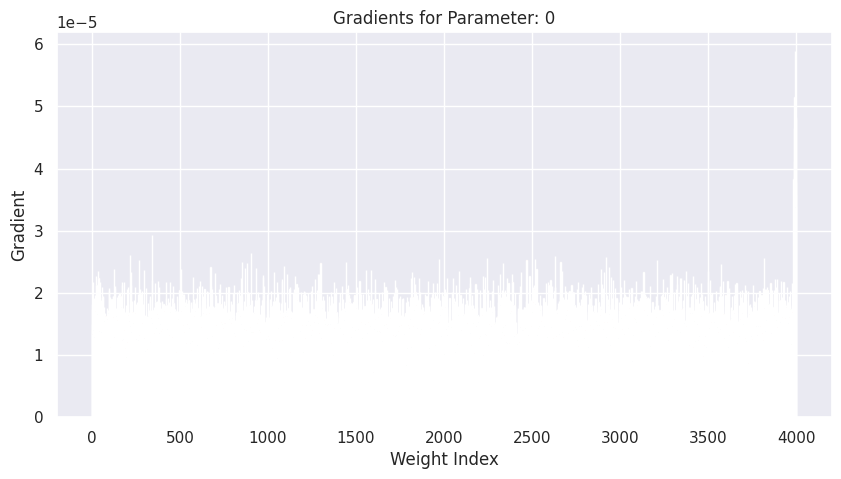

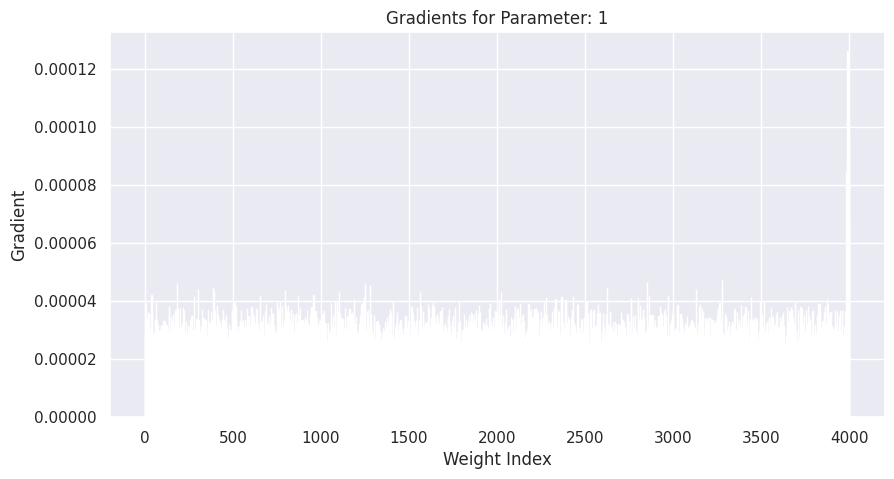

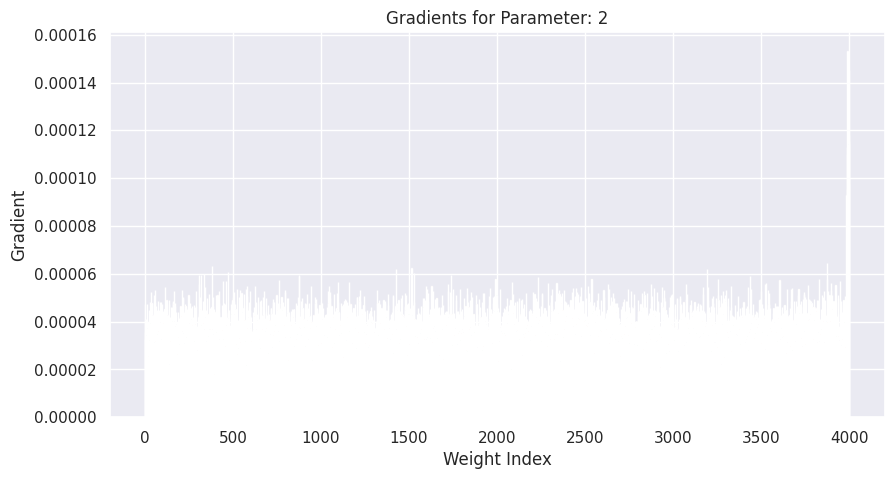

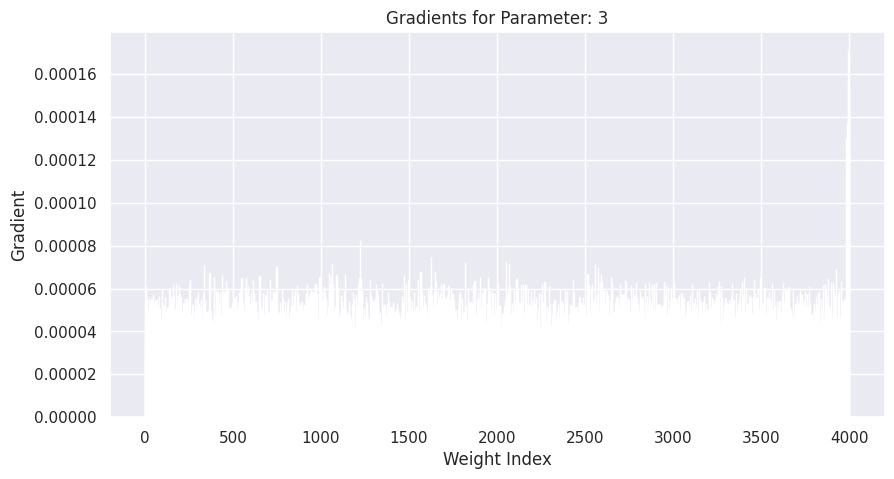

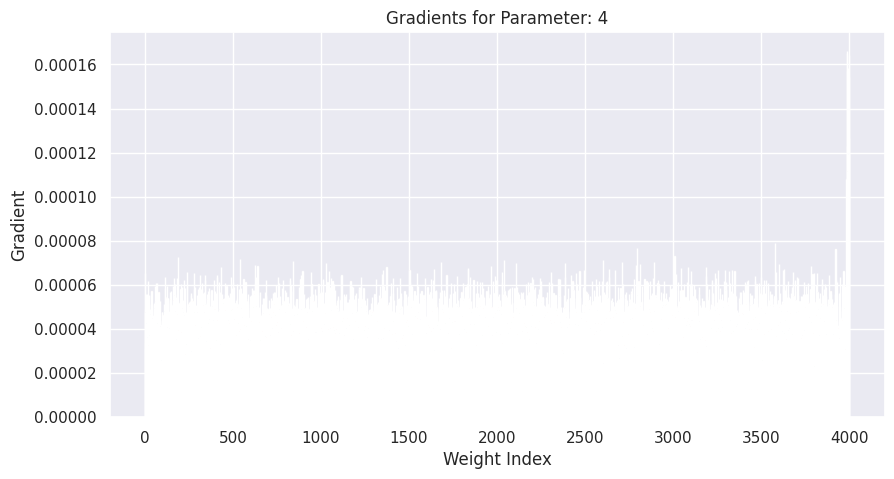

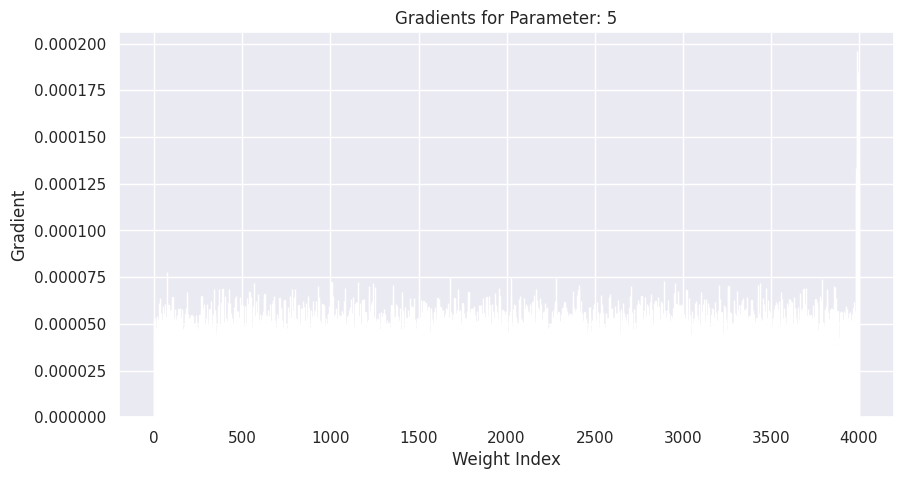

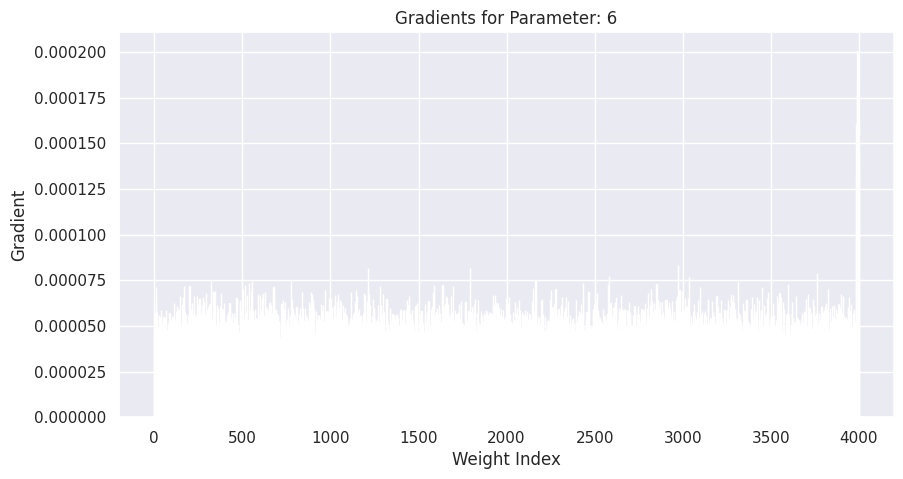

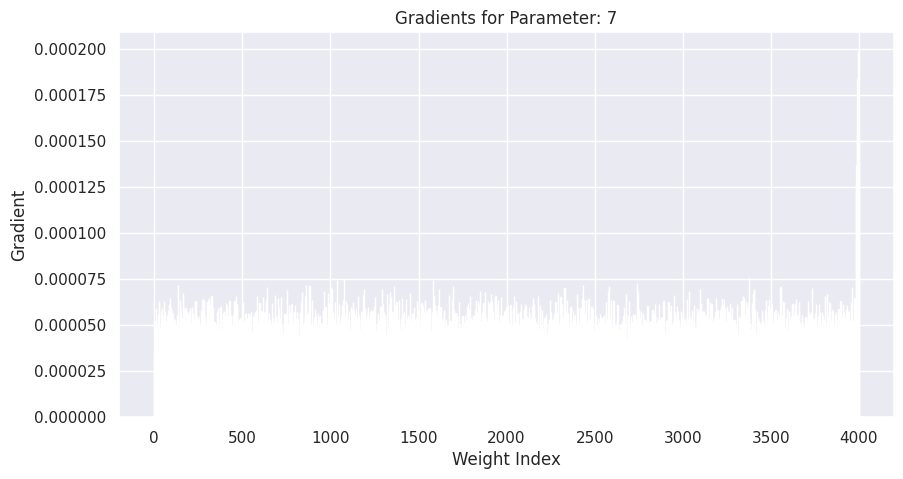

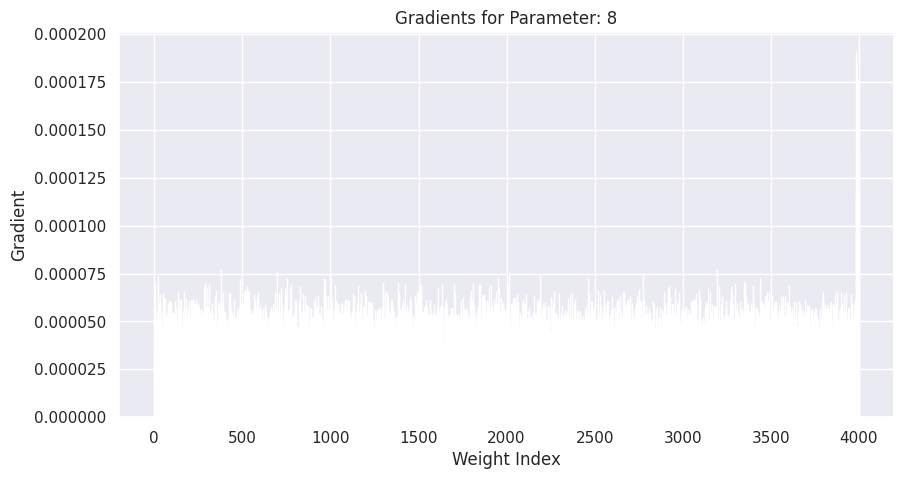

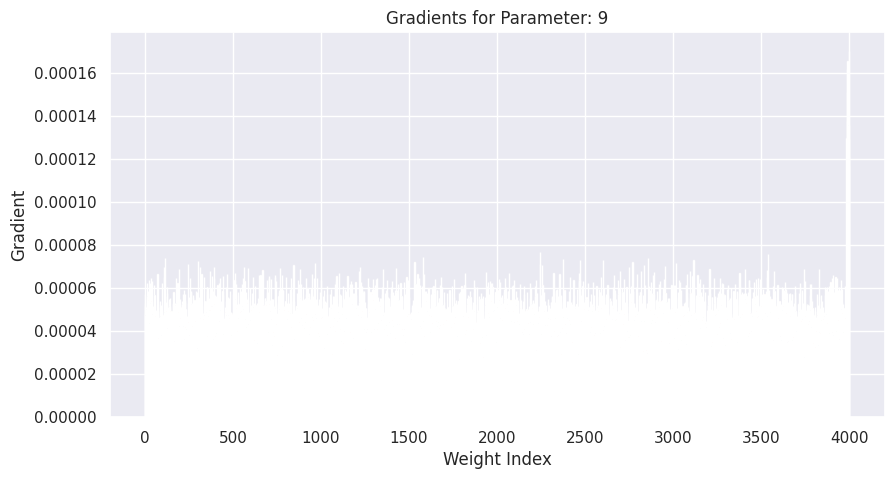

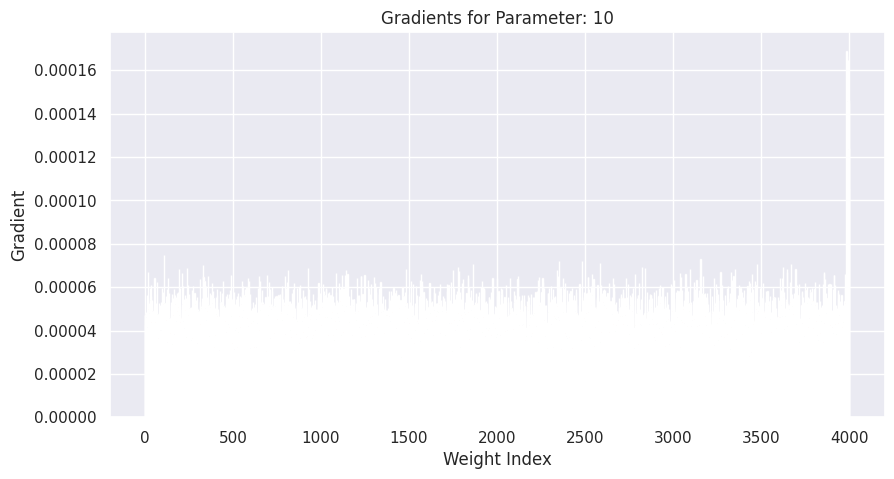

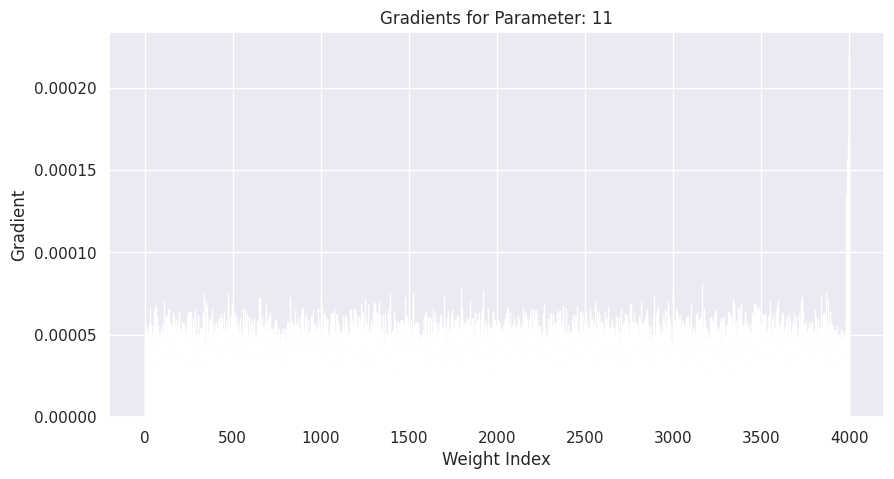

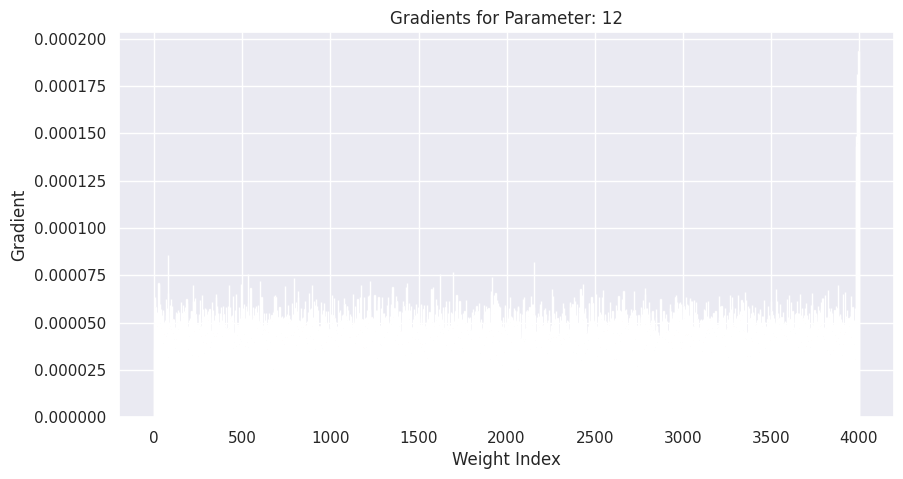

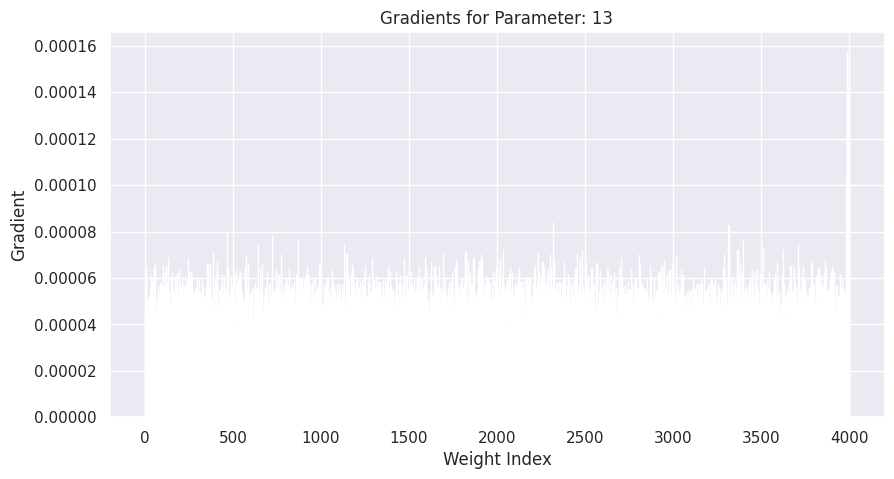

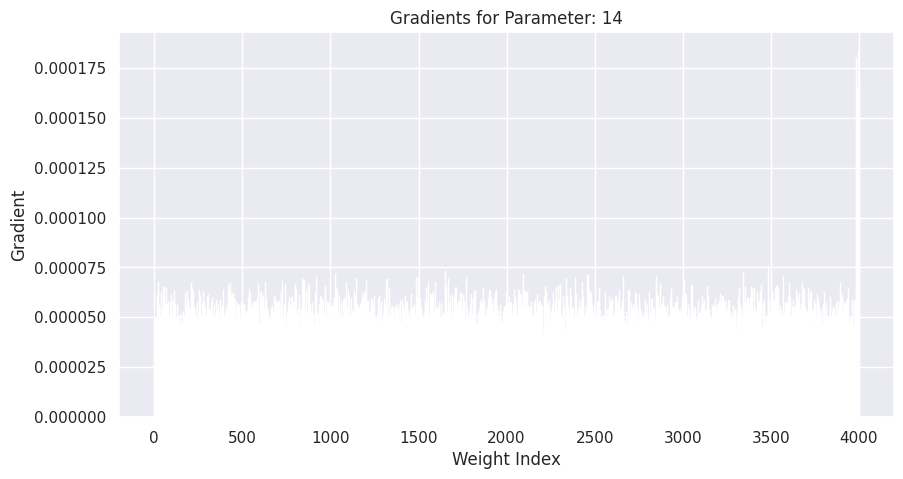

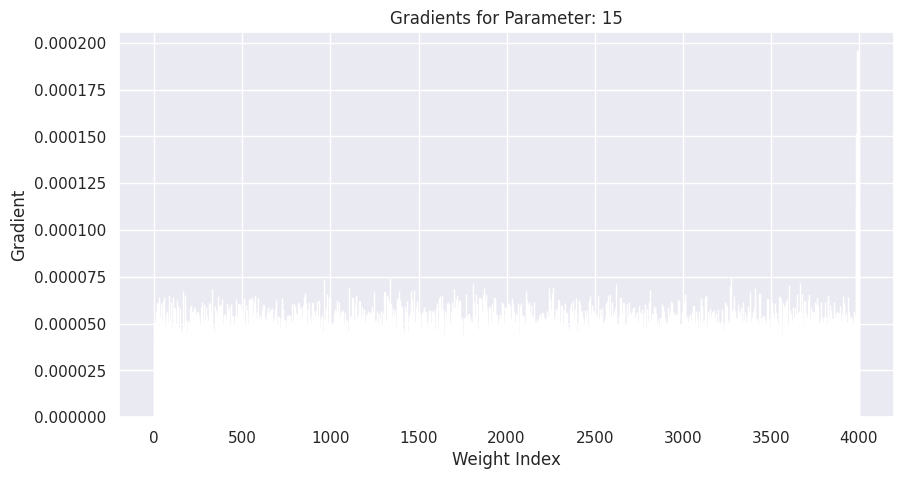

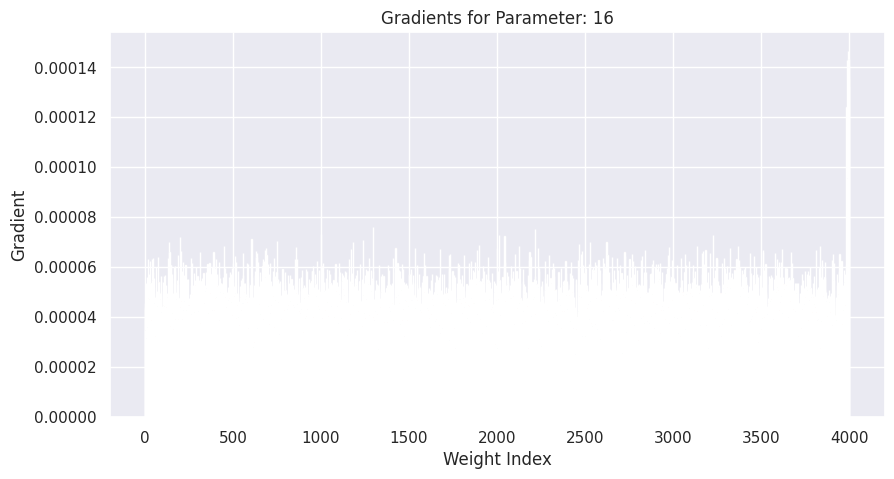

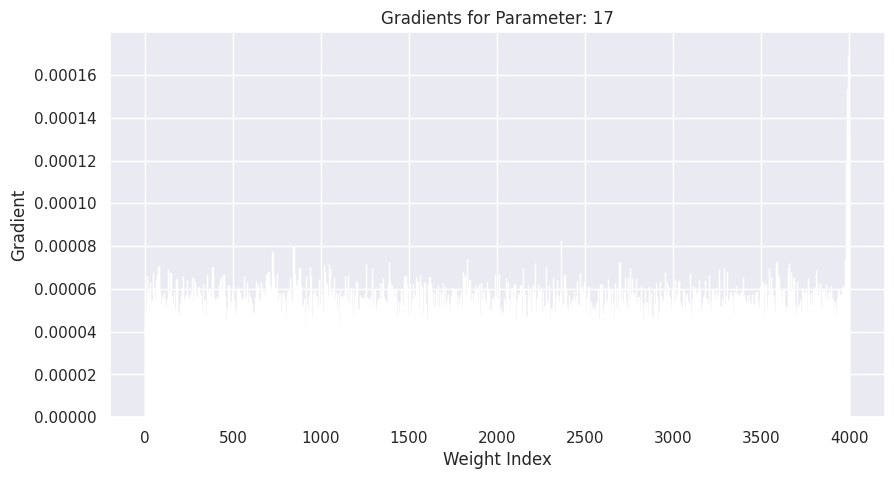

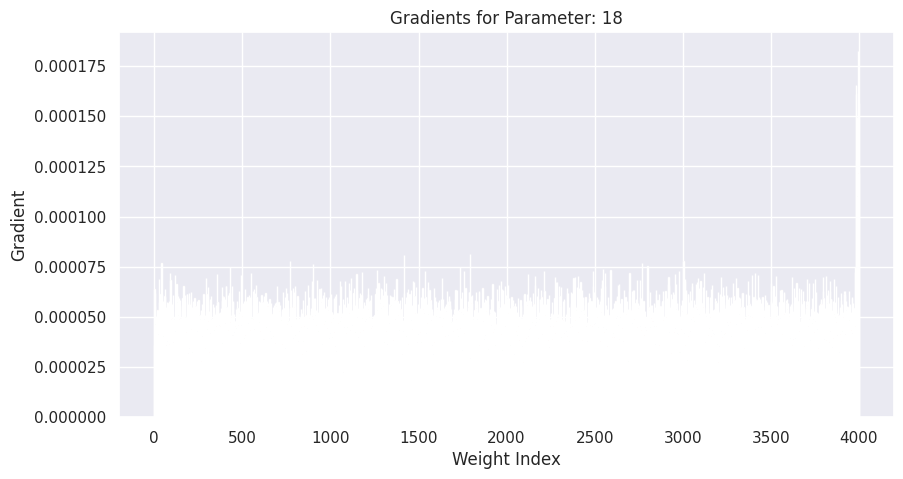

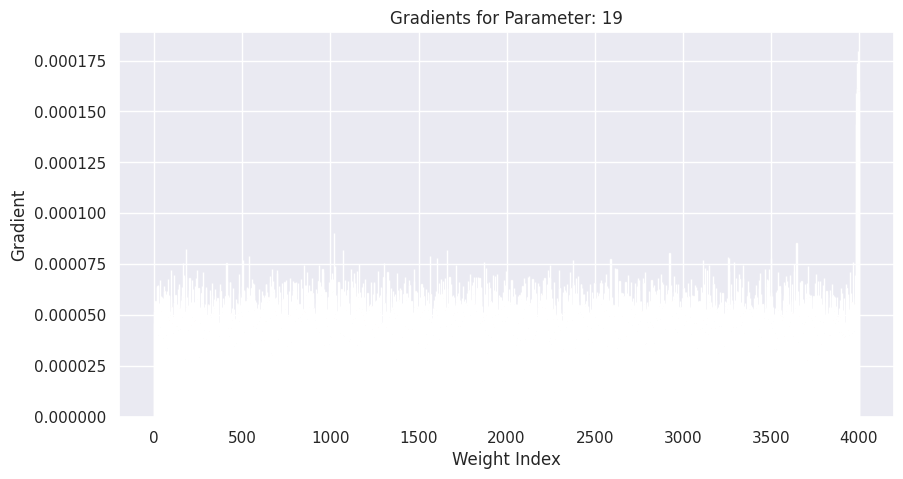

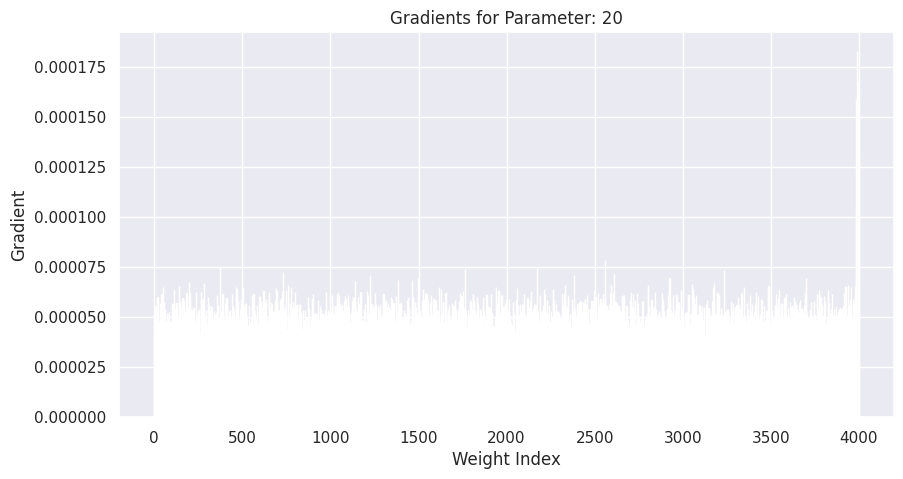

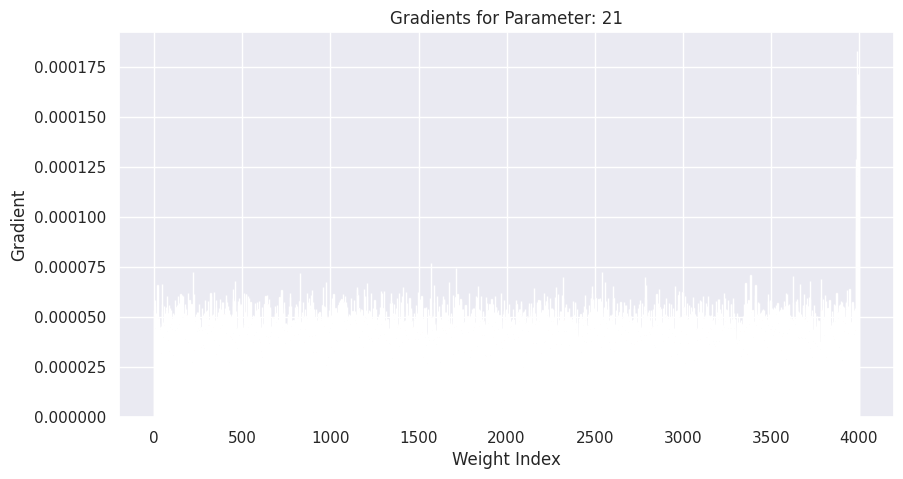

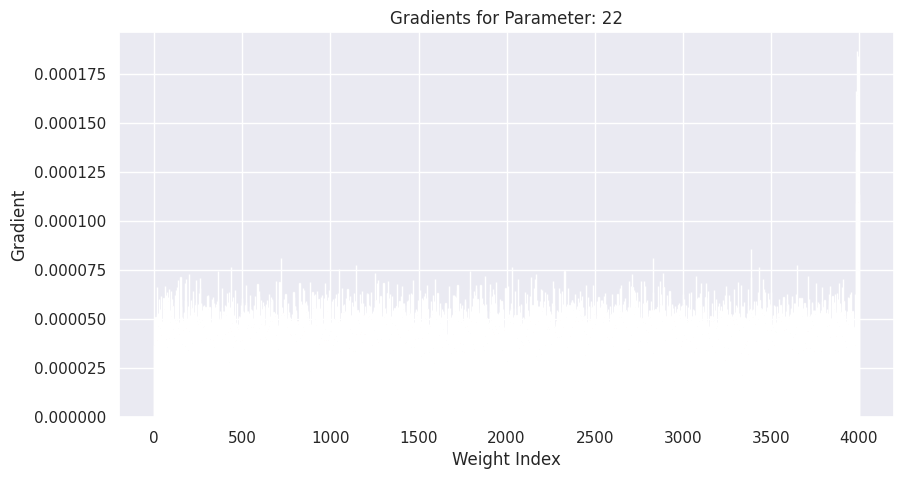

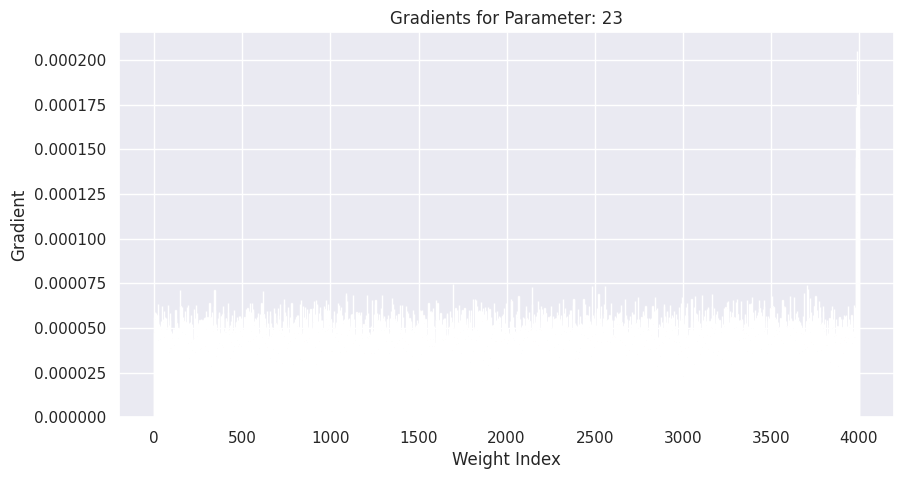

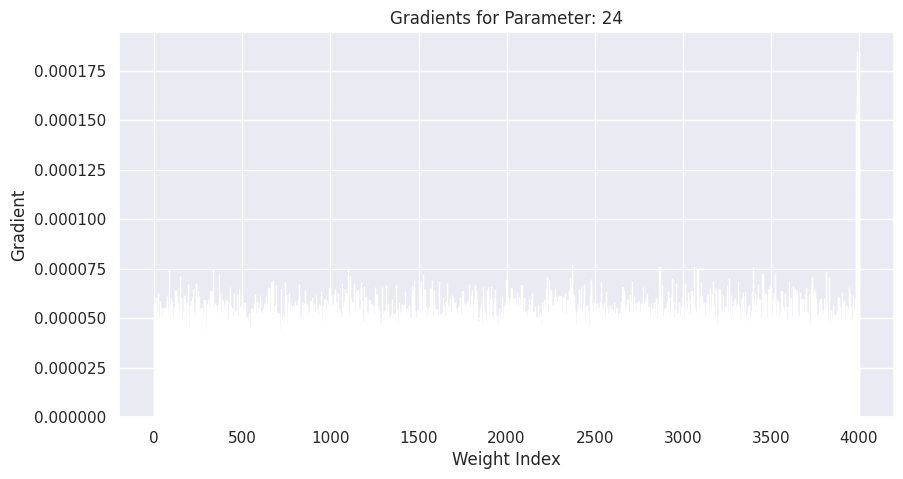

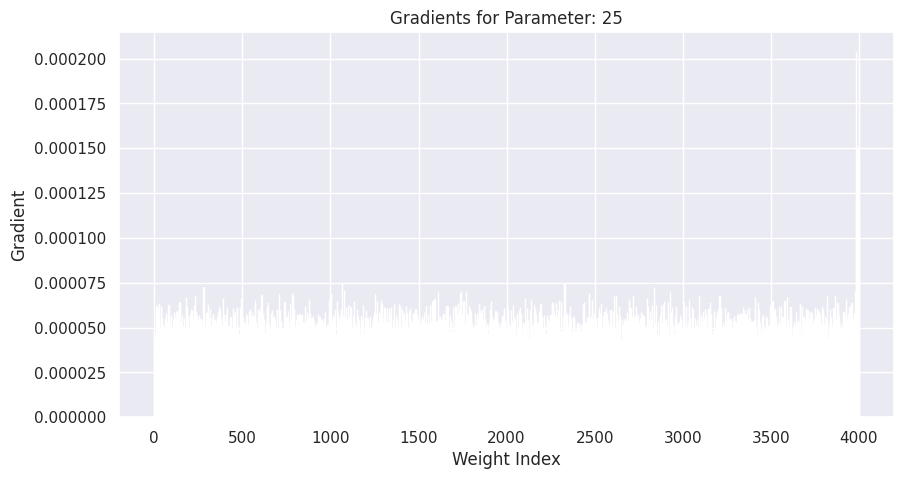

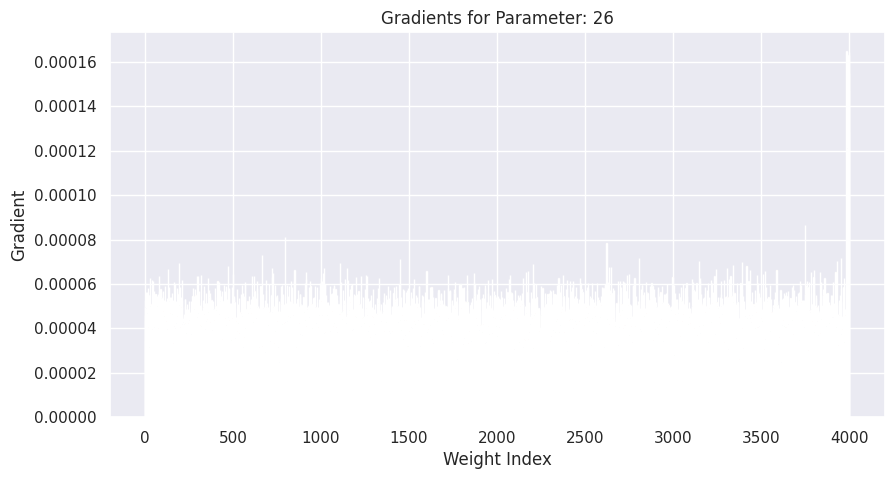

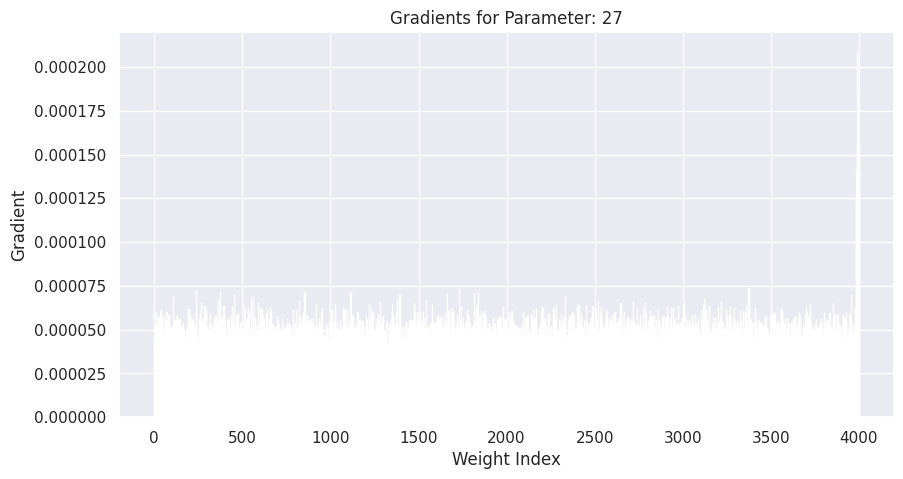

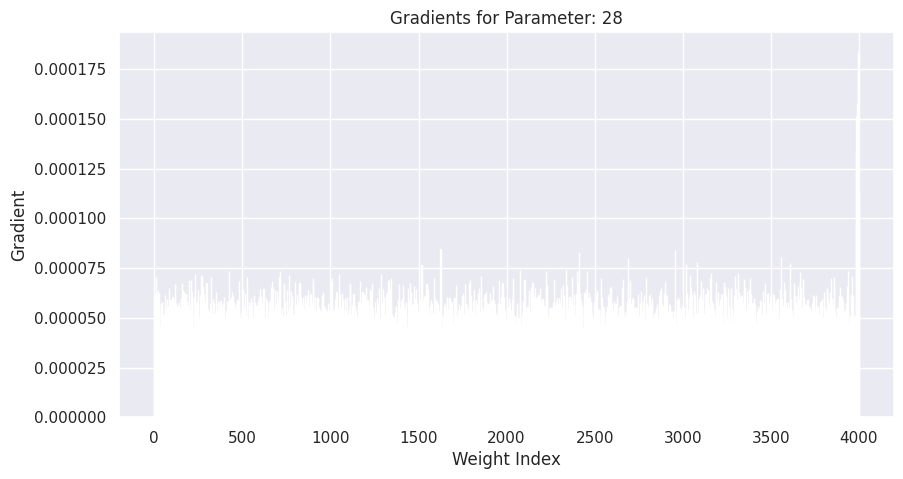

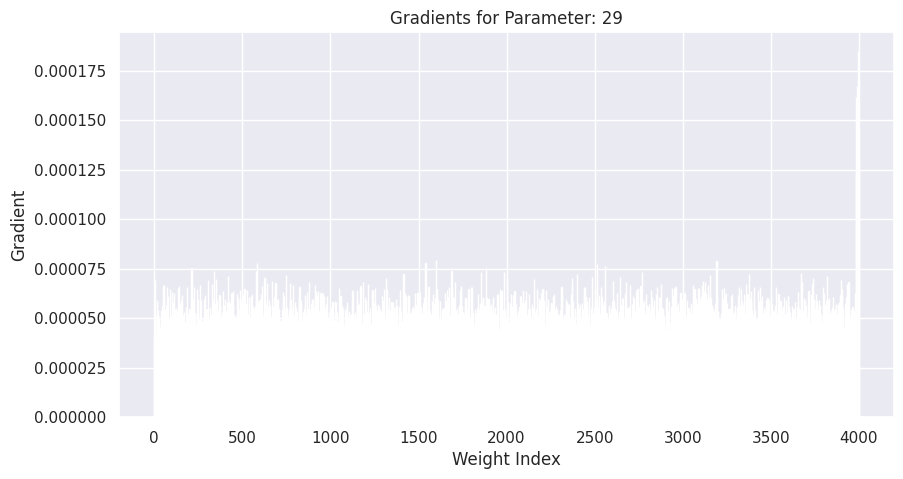

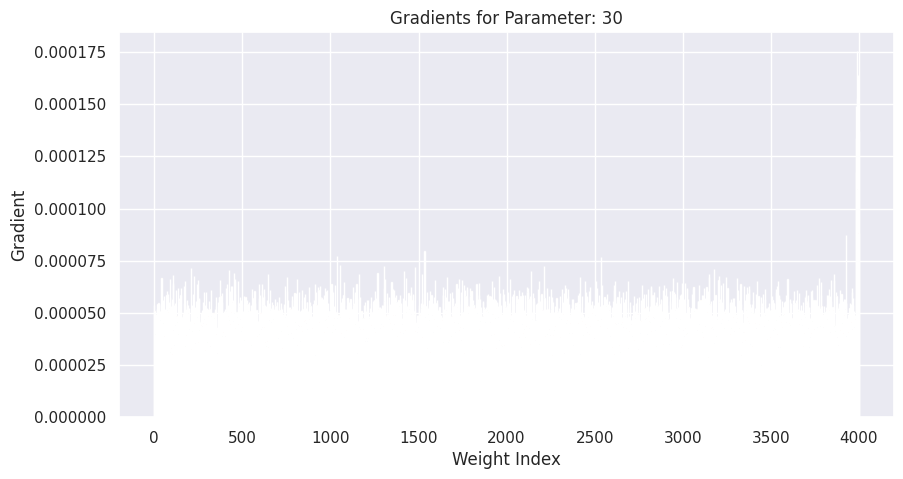

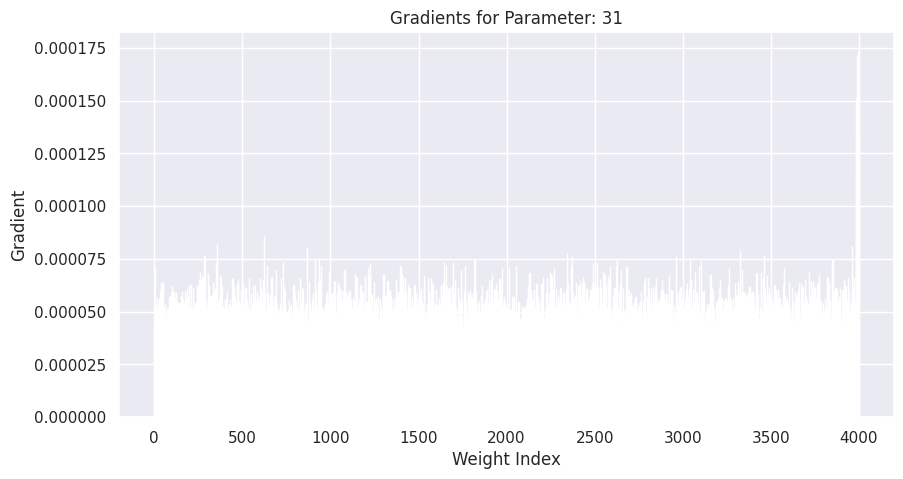

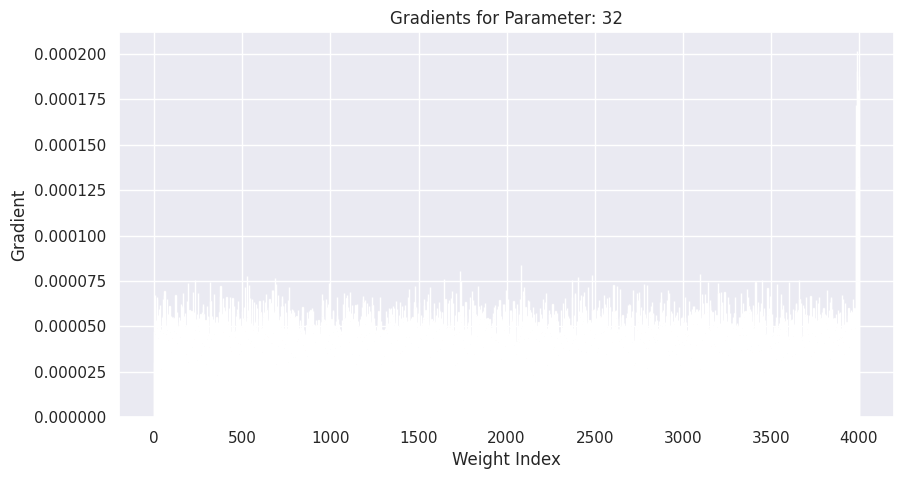

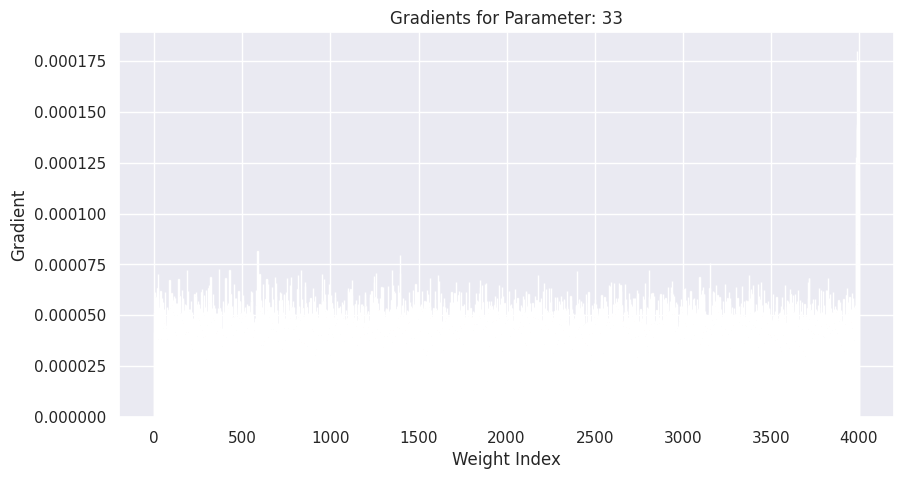

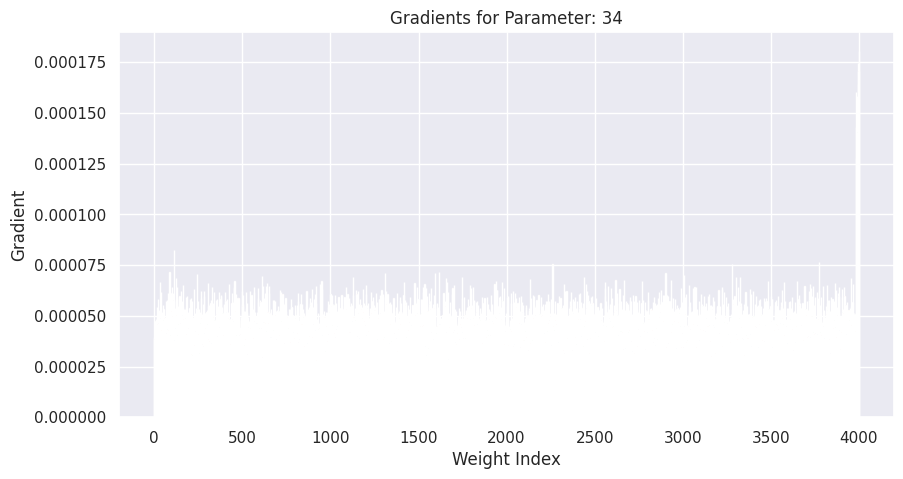

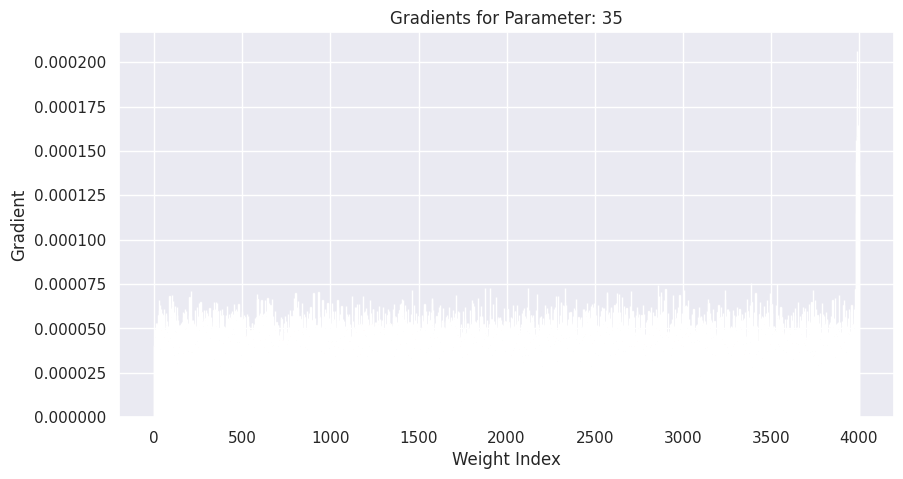

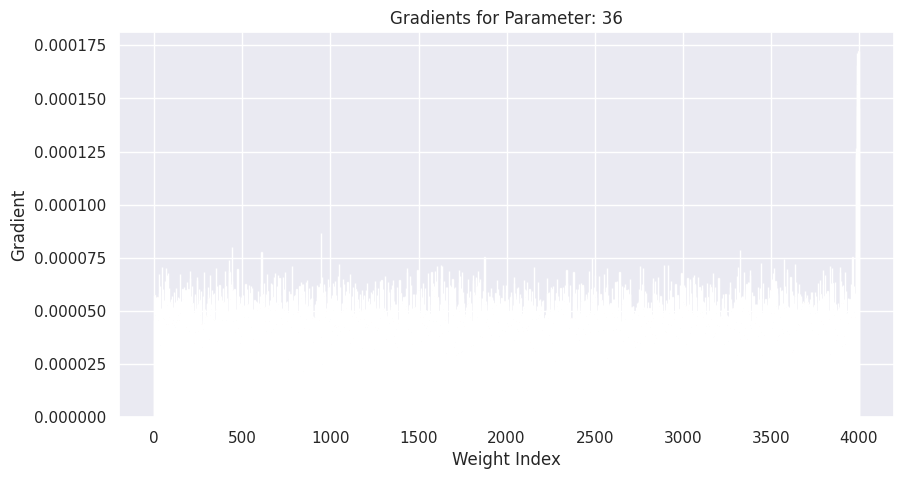

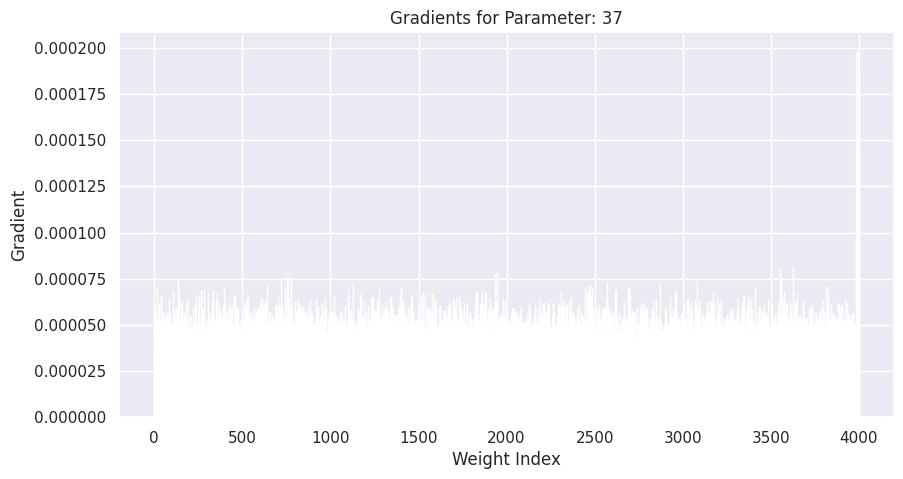

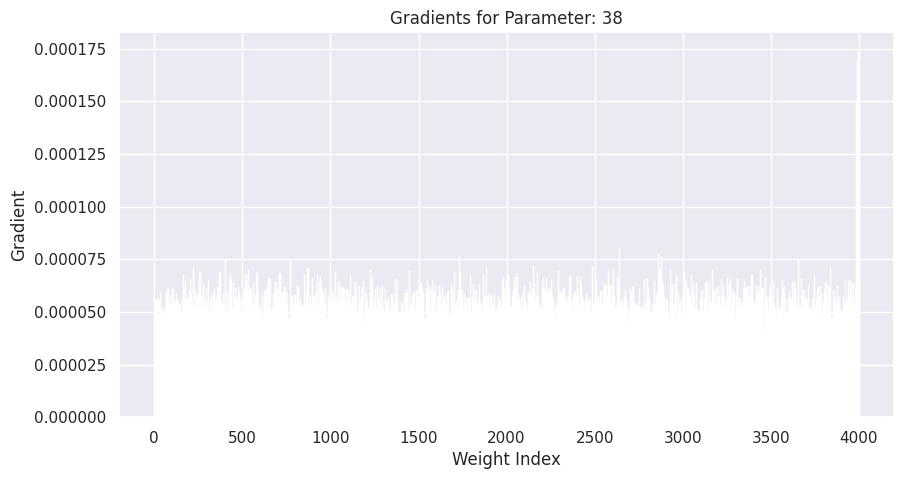

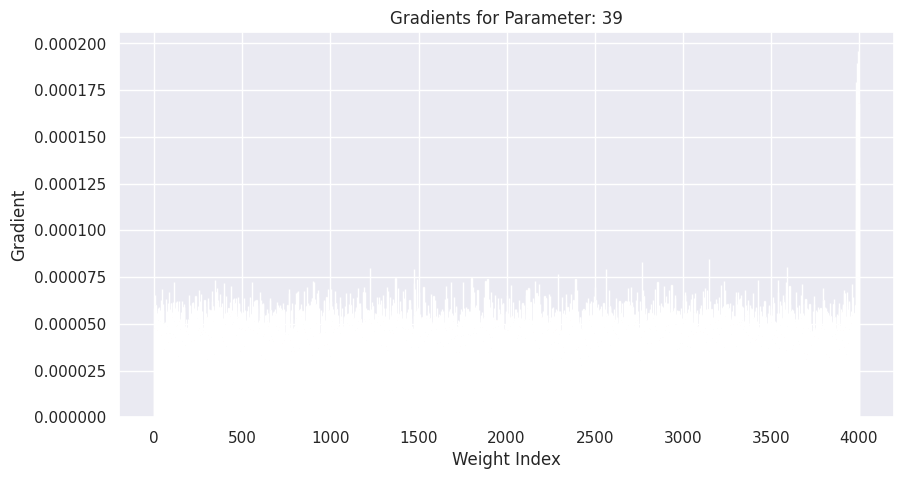

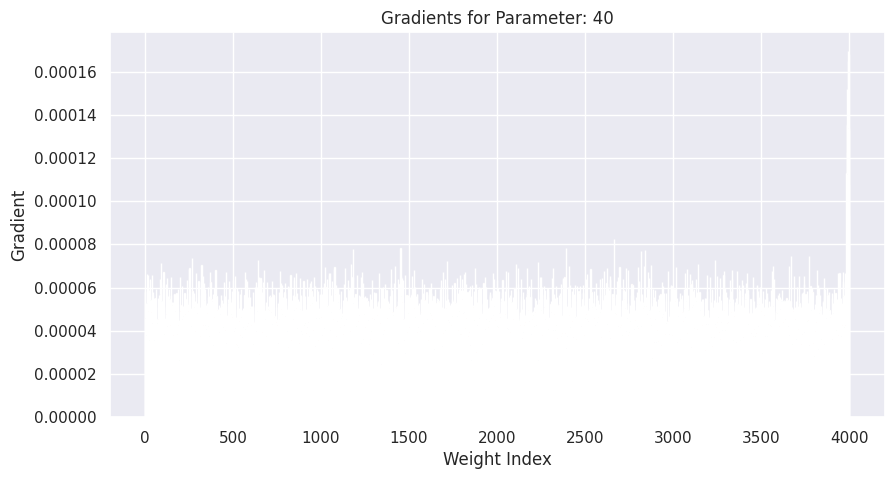

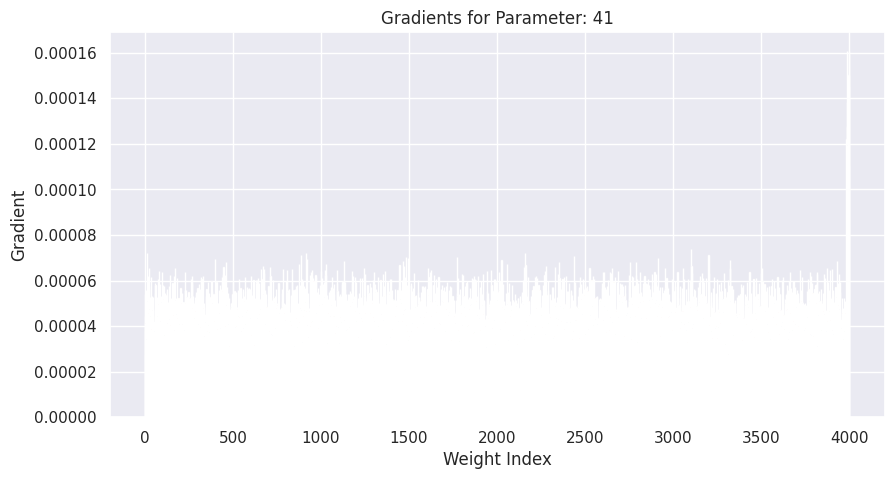

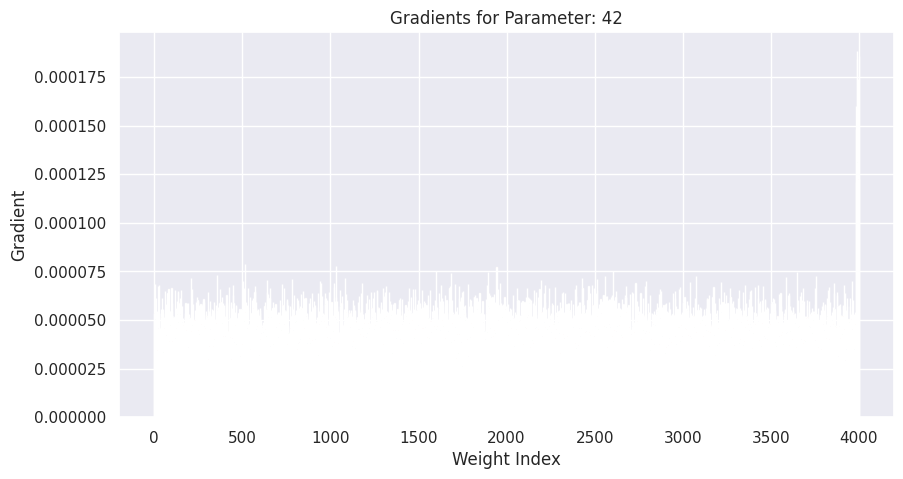

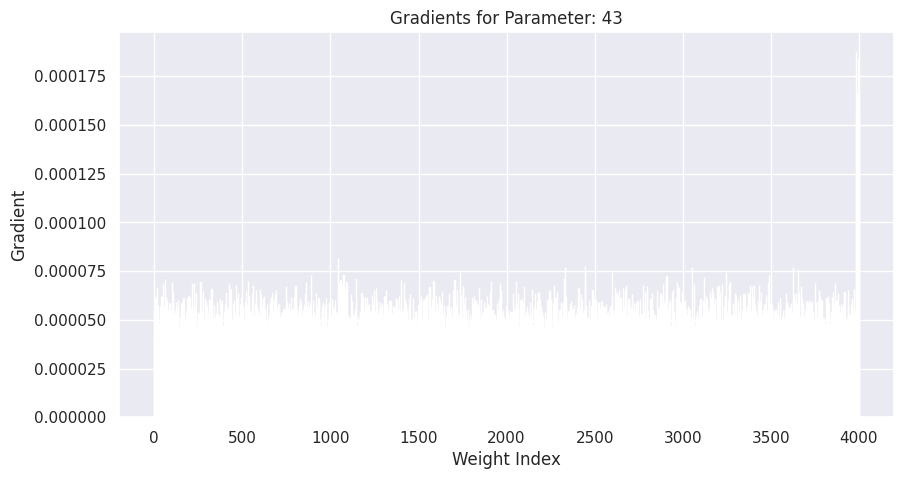

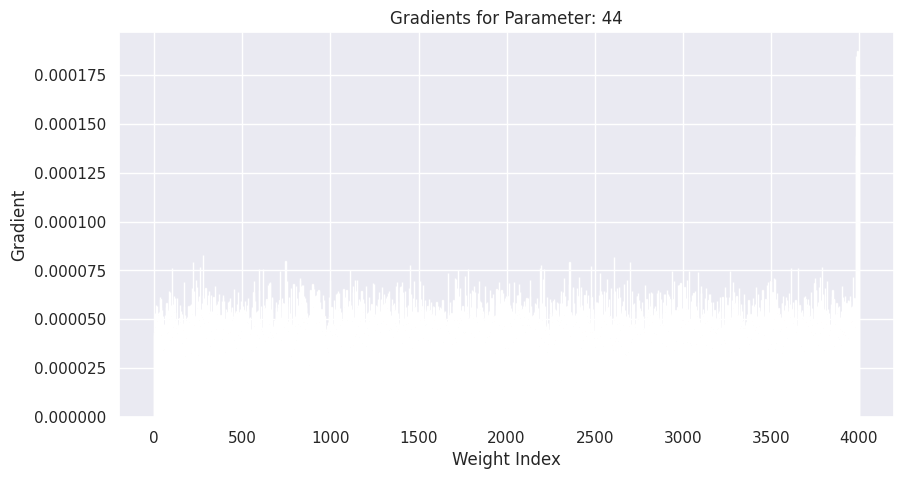

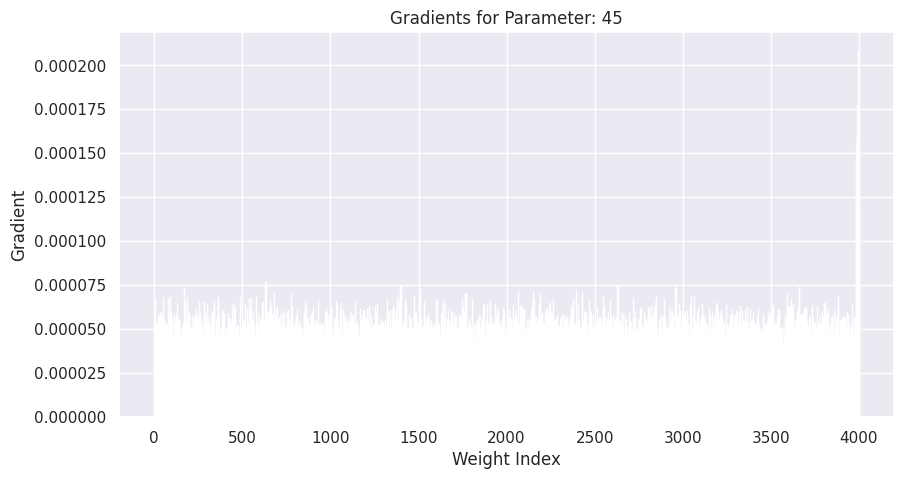

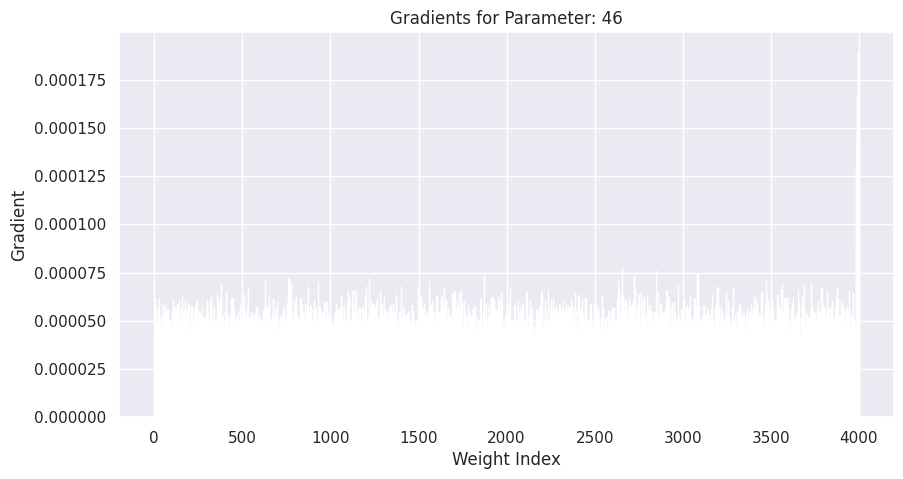

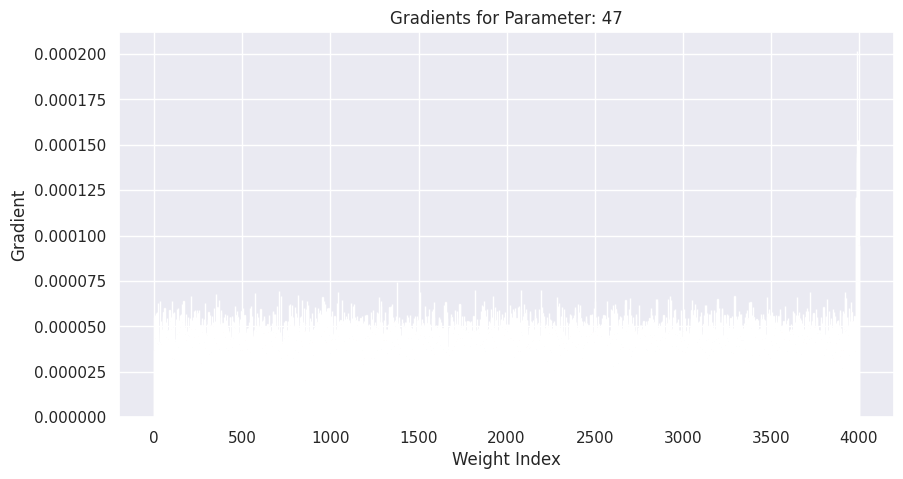

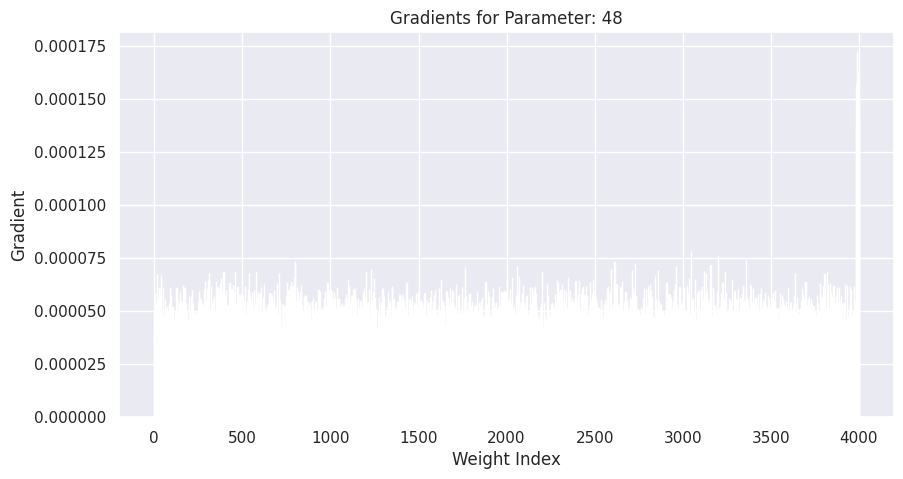

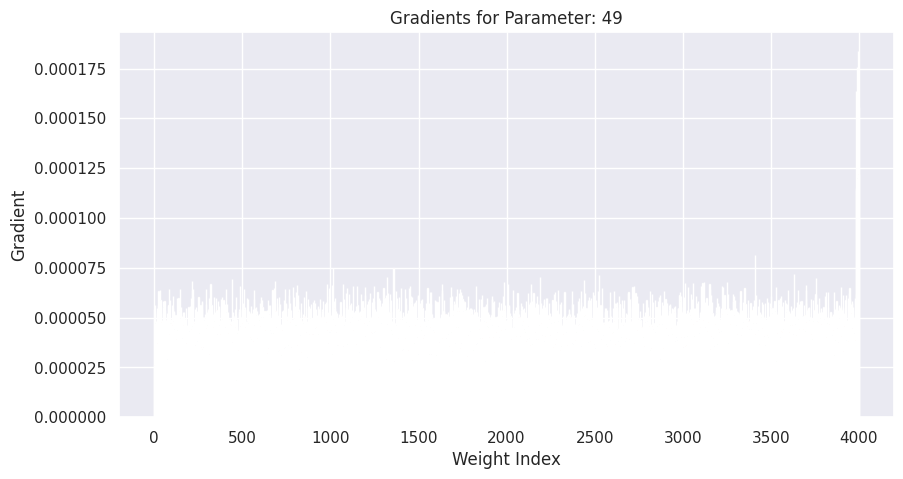

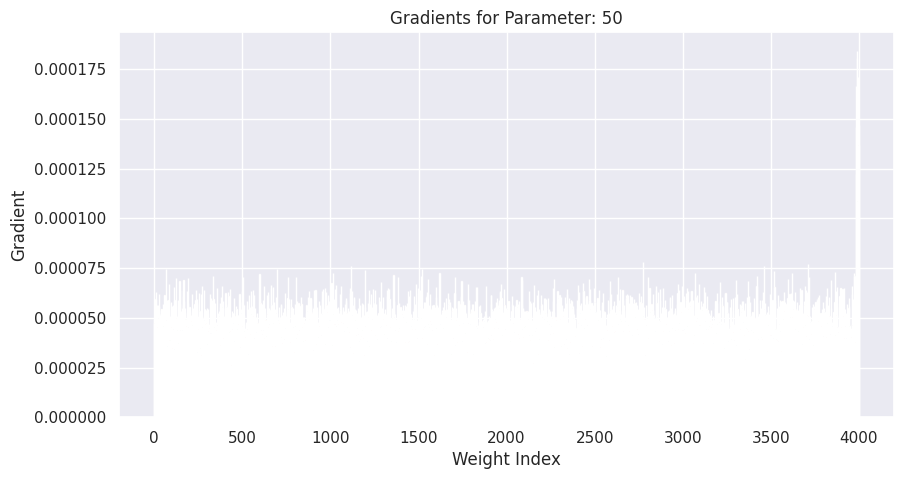

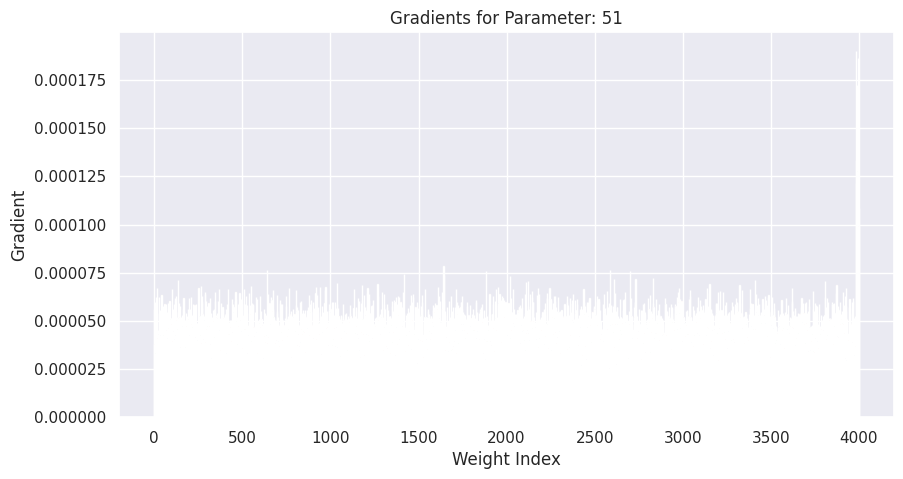

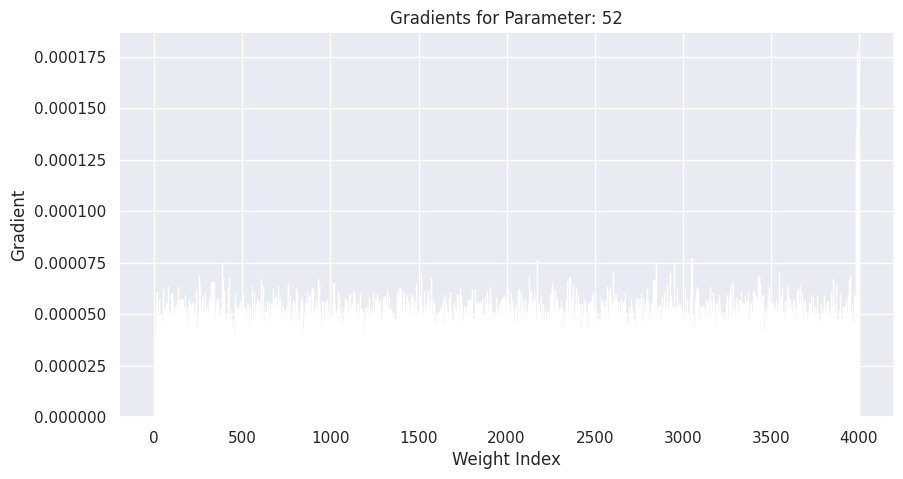

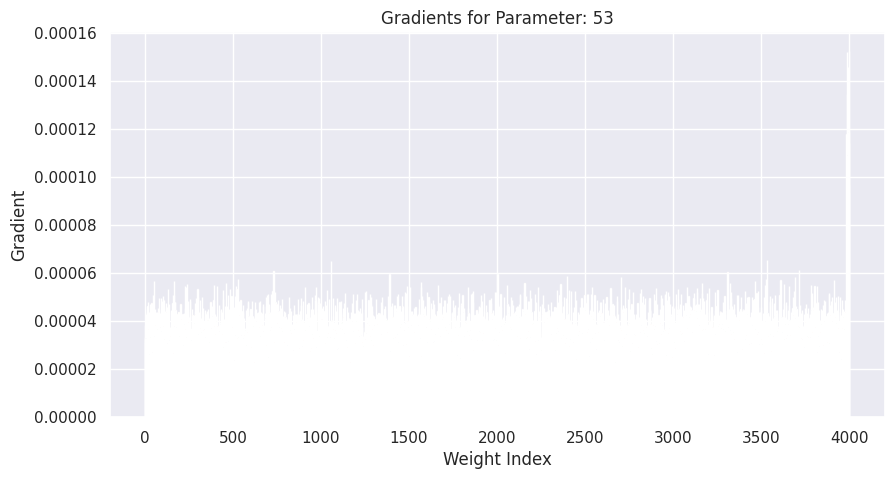

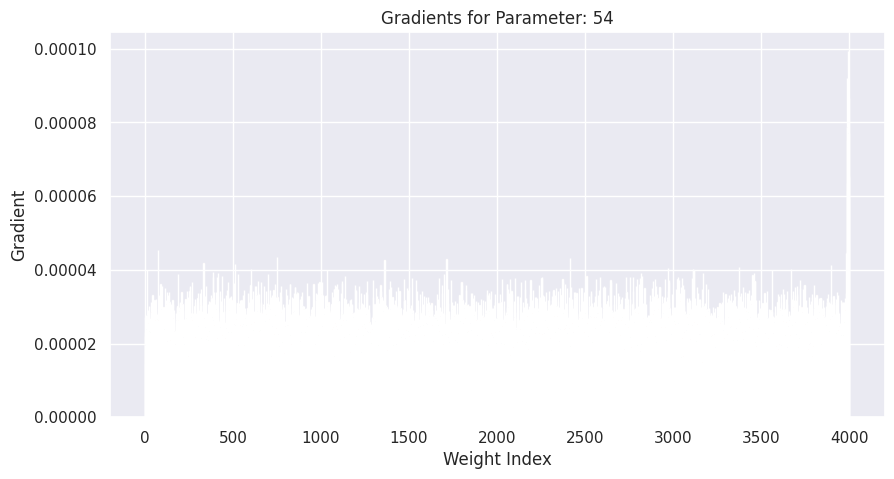

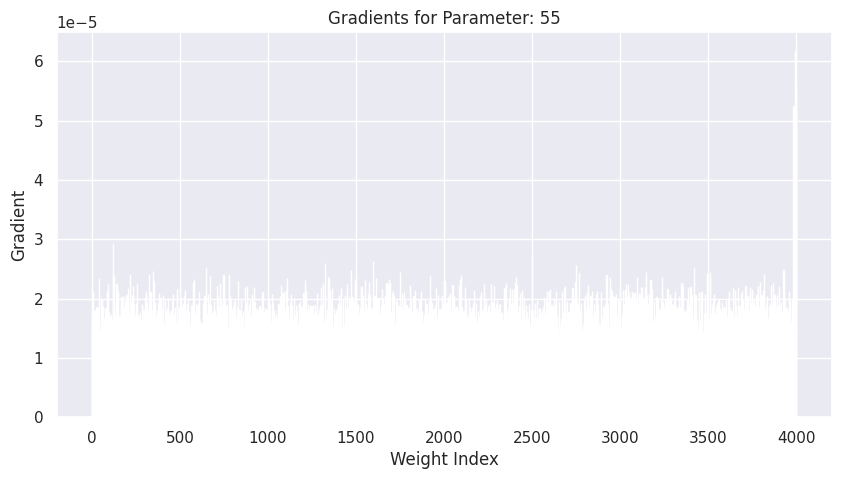

In [10]:
fresh_model = CNN(3, data_latch.num_targets, data_latch.num_instances,)
fresh_gradients = collect_gradients(fresh_model, data_loader_train)

import matplotlib.pyplot as plt

# Define custom colors for the bar plot
bar_colors = ['steelblue', 'darkorange', 'limegreen', 'red', 'purple']

# Iterate over the weight parameters and their gradients
for param_name, gradients in fresh_gradients.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(gradients)), gradients, color=bar_colors)
    plt.xlabel('Weight Index')
    plt.ylabel('Gradient')
    plt.title(f'Gradients for Parameter: {param_name}')
    plt.show()